In [9]:
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd

import tensorflow as tf

import matplotlib
from matplotlib import pyplot as plt

matplotlib.style.use('ggplot')
%matplotlib inline

# Dummy dataset
-------

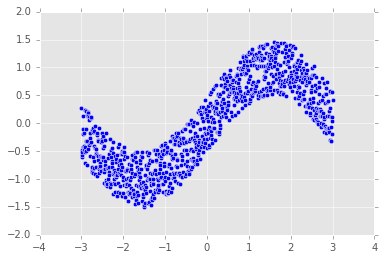

In [10]:
num_obs = 1000
xData = np.linspace(-3.0,3.0,num_obs)
xData = np.array(xData, dtype='float32')
yData = np.sin(xData) + np.random.uniform(-0.5, 0.5, num_obs)   # creating a sine function by adding random noise
yData = np.array(yData, dtype='float32')
plt.scatter(xData, yData)

# Intuition for Weight Initialization:
--------

In [4]:
sess = tf.InteractiveSession()

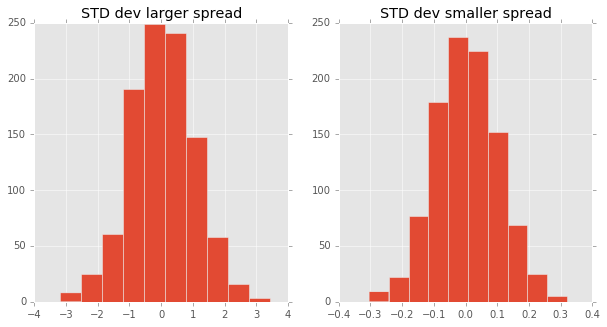

In [5]:
# Build a random normal weight
w_bad = tf.random_normal([num_obs]).eval()  

# NOTE: we use a standard deviation of 0.1 because the first plot is 
# spread out to values from -4 to 4 which is large and we want the 
# spread from the weights to be less to avoid large gradients
w_good = tf.random_normal([num_obs], stddev=0.1).eval()

fig, axs = plt.subplots(1,2,figsize=(10,5))#,facecolor='y', edgecolor='k')
axs[0].hist(w_bad)
axs[0].set_title('STD dev larger spread')
axs[1].hist(w_good)
axs[1].set_title('STD dev smaller spread')

# Running a Neural Net (Linear Function) | Full Batch
---------

#### Initialize Variables and Graph for the cost Function

In [6]:
numDataPoints = 1000
numOutUnits = 1
numFeatures = 1

x = tf.placeholder(tf.float32, [numDataPoints, numFeatures], name='x')   # Where 1000 is the number of data points
y = tf.placeholder(tf.float32, [numDataPoints], name='y')

# Let us create only one input weight because we have only one input dimension
w = tf.Variable(tf.random_normal([numFeatures,numOutUnits], dtype=tf.float32, stddev=0.1), name='weight')
b = tf.Variable(tf.constant([numOutUnits], dtype=tf.float32), name='bias')
y_pred = tf.matmul(x,w) + b

# Now we shall convert the nd (2D tensor) into a 1D tensor, as the input y
# is a 1D tensor. Conversion would make it easy for us to compare the
# Prediction y with the actually
y_pred = tf.reshape(y_pred, [numDataPoints])

In [7]:
# Now that we have computed the graph to calculate the y_pred.
# We have to define a cost function.
# The cost function for us would simply be the distance between 
# the actual y and the y_pred. We can also have a more complicated cost fucntinon
# such as euclidian distance, geodesic distance or what ever distance metric you want
# This distance is minimized using tensorflow optimization technique
# and in doing so the value weights and bias that minimizes most is used for test data

def distance(yInput, y_predInput):
    return tf.abs(yInput - y_predInput)  # Returns the L1 norm distance function

def learn(yInput, y_pred, learning_rate):
    costFunction = distance(yInput, y_pred)
    cost = tf.reduce_mean(costFunction)   # This is just the mean of the error.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(cost)
    return cost, optimizer

#### Build the graph and plot the output for several iteration (Full Batch learning)

In [8]:
def fullBatchLearning(xInput, yInput, y_pred, learning_rate):
    num_iteration = 500

    # The Cost function is the mean squared error
    cost = tf.reduce_mean(tf.squared_difference(y, y_pred))
    # tf.reduce_sum(tf.pow(Y1 - Y2, 2)) / (reduce(lambda x, y: x*y, shape_obj))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(cost)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        prev_trainingCost = 0.0

        for i in np.arange(num_iteration):
            sess.run(optimizer, 
                     feed_dict={
                         x : xInput,
                         y : yInput
                     })

            trainingCost = sess.run(cost,
                                   feed_dict={
                                       x : xInput,
                                       y : yInput
                                   })

            if (i%10 == 0 or i== num_iteration-1):
                pred = y_pred.eval(feed_dict={x : xInput},
                                   session = sess)  
                # When we use the session in the eval(), 
                # then we ensure that the ouptut is computed by 
                # using the lastest values of the session sess

                axs.plot(xInput, pred, 'k', alpha= (i+50)/num_iteration)
                fig.show()
                plt.draw()    

                print (trainingCost)
            # We print the training cost here, see if the cost decreases every iteration,
            # if so then we assume that the network is learning weights

            # Sometimes a local minimum is reached before the num_iteration
            # IF so them we would want to terminate the program before the iterations are complete
            if np.abs(prev_trainingCost - trainingCost) < 0.000001:
                break

            prev_trainingCost = trainingCost

#### Run the entire Graph

/Users/sam/App-Setup/CondaENV/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


1.33535
0.907339
0.669335
0.524254
0.431395
0.370558
0.330277
0.303482
0.285622
0.273706
0.265753
0.260445
0.256901
0.254535
0.252956
0.251901
0.251197
0.250727
0.250414
0.250204
0.250064
0.249971
0.249909
0.249867
0.249839
0.249821
0.249808


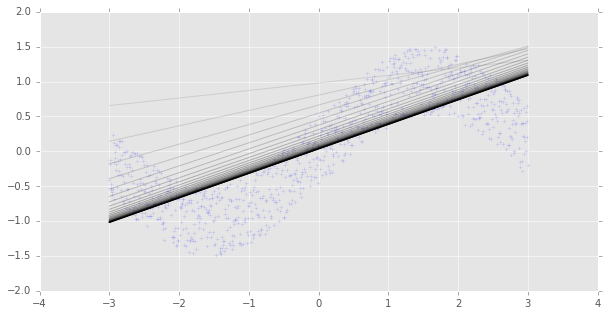

In [10]:
fig, axs = plt.subplots(1,1,figsize=(10,5))#,facecolor='y', edgecolor='k')
axs.scatter(xData, yData, alpha=0.15, marker='+')

xDataND = xData.reshape(numDataPoints, numFeatures)
# xDataND = xData.reshape(numDataPoints, numFeatures)

fullBatchLearning(xInput=xDataND, 
          yInput=yData,
          y_pred=y_pred,
          learning_rate=0.01)

# Running a Neural Net (Linear Function) | Mini Batch
---------

#### Initialize the inputs and graph variables

In [11]:
numFeatures = 1
numOutUnit = 1

x = tf.placeholder(dtype=tf.float32, shape=[None, numFeatures], name='x')
y = tf.placeholder(dtype=tf.float32, shape=[None], name='y')

w = tf.Variable(tf.random_normal(dtype=tf.float32, shape=[numFeatures, numOutUnits], stddev=0.1), name='weight')
b = tf.Variable(tf.constant([numOutUnits], dtype=tf.float32), name='bias')

# y_pred = x*w + b
y_pred = tf.matmul(x,w) + b
# We would like to convert the 2d tensor into 1d tensor for compatibility
y_pred = tf.reshape(y_pred, [-1])  # similar to np.flatten

#### Build the graph and plot the output for several iteration (Mini Batch learning)

In [14]:
def miniBatchLearning(xInput, yInput, y_pred, learning_rate, numDataPoints, batchSize, numBatches, num_iteration=False):
    if not num_iteration:
        num_iteration = 500    
        
    print ('The mini Batch Size is: ', batchSize)
    print('Number of mini batches is: ', numBatches)
    print('Length of xInput is: ', len(xInput))
    print('Length of yInput is: ', len(yInput))
    
    print('shape of tensor object x is: ', x.get_shape().as_list())
    print('shape of tensor object y is: ', y.get_shape().as_list())
    print('shape of tensor object y_pred is: ', y_pred.get_shape().as_list())

    ###############################
    # Cost function and Optimizer
    cost = tf.reduce_mean(tf.squared_difference(y, y_pred))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(cost)
    ###############################
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        prev_trainingCost = 0.0

        for i in np.arange(num_iteration):
            ###############################
            # Create indices for mini batch
            # It is good to provide different
            # combination of example as different
            # batches
            idxs = np.arange(numDataPoints)
            rand_idxs = np.random.permutation(idxs)
            ###############################
            
            # Call the mini batches
            for batch_i in range(numBatches):
                index = rand_idxs[batch_i * batchSize : (batch_i + 1) * batchSize]
                
#                 print (len(xInput[index]))
#                 print (len(yInput[index]))
                
                sess.run(optimizer, 
                         feed_dict={
                             x : xInput[index],
                             y : yInput[index]
                         })

            trainingCost = sess.run(cost,
                                   feed_dict={
                                       x : xInput,
                                       y : yInput
                                   })

            if (i%10 == 0 or i== num_iteration-1):
                pred = y_pred.eval(feed_dict={x : xInput},
                                   session = sess)  
                # When we use the session in the eval(), 
                # then we ensure that the ouptut is computed by 
                # using the lastest values of the session sess

                axs.plot(xInput, pred, 'k', alpha= (i+50)/num_iteration)
                fig.show()
                plt.draw()    

                print (trainingCost)
            # We print the training cost here, see if the cost decreases every iteration,
            # if so then we assume that the network is learning weights

            # Sometimes a local minimum is reached before the num_iteration
            # IF so them we would want to terminate the program before the iterations are complete
            if np.abs(prev_trainingCost - trainingCost) < 0.000001:
                break

            prev_trainingCost = trainingCost

#### Run the entire Graph with mini batches

(1000, 1)
The mini Batch Size is:  100
Number of mini batches is:  10
Length of xInput is:  1000
Length of yInput is:  1000
shape of tensor object x is:  [None, 1]
shape of tensor object y is:  [None]
shape of tensor object y_pred is:  [None]
0.969713


/Users/sam/App-Setup/CondaENV/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


0.260805
0.249982
0.249788


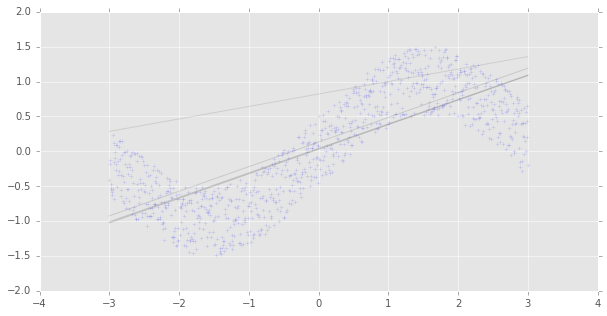

In [13]:
# We creates mini batches

fig, axs = plt.subplots(1,1,figsize=(10,5))#,facecolor='w', edgecolor='k')
axs.scatter(xData, yData, alpha=0.15, marker='+')

numDataPoints = 1000
numBatches = 10
batchSize = numDataPoints // numBatches

xDataND = xData.reshape(numDataPoints, numFeatures)
print (xDataND.shape)

miniBatchLearning(xInput=xDataND, 
                  yInput=yData,
                  y_pred=y_pred,
                  learning_rate=0.001,
                  numDataPoints=numDataPoints,
                  batchSize=batchSize, 
                  numBatches=numBatches)

# Running a Neural Net (Polynomial Function) | Mini Batch
---------

We observe that with a polynomial degree of 2 there is not very mych improvement in the model. Using a polynomial degree of 3 improves the model as some decision boundary replicates a sine wave curvature which best fits the training data.

#### Build Polynomial Features

In [31]:
# First we create a quadratic data.
from sklearn import preprocessing
polynomialDegree = 3

# Build Polynomial Features
polyFeature = preprocessing.PolynomialFeatures(degree=polynomialDegree, include_bias=False)
xDataPoly = polyFeature.fit_transform(np.array(xData.reshape(-1, 1), dtype='float32'))
print (xDataPoly)

# Standarize the input
xDataPolyScaled = preprocessing.scale(xDataPoly)
# xDataPolyScaled = scaling.fit_transform(xDataPoly)
print (xDataPolyScaled)

print (xDataPolyScaled.mean(axis=0))
print (xDataPolyScaled.std(axis=0))

[[ -3.           9.         -27.        ]
 [ -2.993994     8.96399975 -26.83816147]
 [ -2.987988     8.92807198 -26.67697144]
 ..., 
 [  2.987988     8.92807198  26.67697144]
 [  2.993994     8.96399975  26.83816147]
 [  3.           9.          27.        ]]
[[-1.73032033  2.22936845 -2.63783002]
 [-1.72685623  2.21597886 -2.62201881]
 [-1.72339213  2.20261598 -2.60627079]
 ..., 
 [ 1.72339213  2.20261598  2.60627079]
 [ 1.72685623  2.21597886  2.62201881]
 [ 1.73032033  2.22936845  2.63783002]]
[  1.32322313e-08   4.24385078e-08  -2.62260436e-09]
[ 1.00000048  0.9999994   0.99999976]


/Users/sam/App-Setup/CondaENV/lib/python3.5/site-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/sam/App-Setup/CondaENV/lib/python3.5/site-packages/sklearn/preprocessing/data.py:177: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


### By Transforming the input Data

#### Initalize variables and graph lineage for the cost function

In [57]:
numDataPoints = 1000
numFeatures = xDataPolyScaled.shape[1]
numOutUnits = 1

# Initialize the input placeholders
x = tf.placeholder(tf.float32, [None,numFeatures], name='x')   # [1000,2] ---> [num_dataPoints, numFeatures]
print (x.get_shape().as_list())
y = tf.placeholder(tf.float32, [None], name='y')

# Let us create only one input weight because we have only one input dimension
w = tf.Variable(tf.random_normal(dtype=tf.float32, shape=[numFeatures, numOutUnits], stddev=0.1), name='weight')   # [None,1] ---> [numFeatures, output]
# Here [2] indicates the number of weight for features
b = tf.Variable(tf.constant([numOutUnits], dtype=tf.float32), name='bias')
# Here [1] indicates the number of bias, since we are only using only one layer with only one unit we use only one bias

y_pred = tf.matmul(x, w) + b  
# We have to reshape out y_pred because, we want it to produce a output of shape [batchSize],
# since we find the minimum squared loss and compare y_pred with y for every batch.
# For a particular batch y would have dimension [batchSize]
y_pred = tf.reshape(y_pred, [-1])

print (y_pred.get_shape().as_list())

[None, 3]
[None]


#### Run the Entire Graph with mini batch

The mini Batch Size is:  100
Number of mini batches is:  10
Length of xInput is:  1000
Length of yInput is:  1000
shape of tensor object x is:  [None, 3]
shape of tensor object y is:  [None]
shape of tensor object y_pred is:  [None]


/Users/sam/App-Setup/CondaENV/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


1.04619
0.257092
0.201624
0.169931
0.147387
0.131253
0.119704
0.111436
0.105516
0.10128
0.098248
0.0960766
0.0945231
0.0934118
0.0926151
0.0920451
0.0916368
0.0913445
0.091136
0.0909865
0.0908788
0.0908022
0.0907472
0.090708
0.0906797
0.0906596


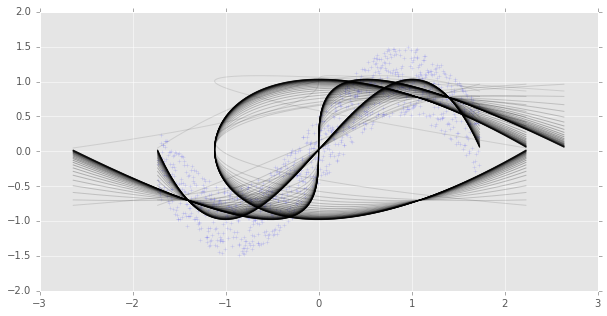

In [59]:
fig, axs = plt.subplots(1,1,figsize=(10,5))#,facecolor='w', edgecolor='k')
axs.scatter(xDataPolyScaled[:,0], yData, alpha=0.15, marker='+')

numDataPoints = 1000
numBatches = 10
batchSize = numDataPoints // numBatches

miniBatchLearning(xInput=xDataPolyScaled, 
                  yInput=yData,
                  y_pred=y_pred,
                  learning_rate=0.001,
                  numDataPoints=numDataPoints,
                  batchSize=batchSize, 
                  numBatches=numBatches)

# Running a Wide Neural Net (Linear Function) | Mini Batch
-----

#### Initialize the Variable and create the graph

In [81]:
numOutUnits = 100
numFeatures = 1

x = tf.placeholder(dtype=tf.float32, shape=[None, numFeatures], name='x')
y = tf.placeholder(dtype=tf.float32, shape=[None], name='y')

w = tf.Variable(tf.random_normal(dtype=tf.float32, shape=[numFeatures, numOutUnits], stddev=0.1), name='weight')
b = tf.Variable(tf.constant(0, shape=[numOutUnits], dtype=tf.float32), name='bais')  # Start with a constant bias of 0

# Get the output from each neuron (output unit)
y_predAll = tf.matmul(x, w) + b

# Average the output from each neuron (ouptut unit) 
y_pred = tf.reduce_sum(y_predAll, 1)

print (y_predAll.get_shape().as_list())
print (y_pred.get_shape().as_list())

[None, 100]
[None]


The mini Batch Size is:  200
Number of mini batches is:  5
Length of xInput is:  1000
Length of yInput is:  1000
shape of tensor object x is:  [None, 1]
shape of tensor object y is:  [None]
shape of tensor object y_pred is:  [None]


/Users/sam/App-Setup/CondaENV/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


4.31032e+07
inf
nan
nan
nan
nan
nan
nan
nan
nan
nan


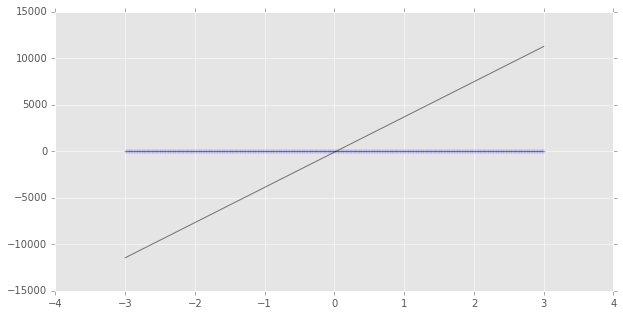

In [82]:
# yDataND = yData.reshape(1000,1)
fig, axs = plt.subplots(1,1,figsize=(10,5))#,facecolor='w', edgecolor='k')
axs.scatter(xData, yData, alpha=0.15, marker='+')

numDataPoints = 1000
numBatches = 5
batchSize = numDataPoints // numBatches

# The input xData is not an nd array, here we convert it into nd array
xDataND = xData.reshape(numDataPoints, 1)
miniBatchLearning(xInput=xDataND, 
                  yInput=yData,
                  y_pred=y_pred,
                  learning_rate=0.02,
                  numDataPoints=numDataPoints,
                  batchSize=batchSize, 
                  numBatches=numBatches,
                  num_iteration=100) 

# Running a Neural Network (Non-Linear Units/Neurons)
--------

Normally to capture the non-linearity in out dataset, we transform the data and add polynomial features. However, we could also use the non-linear activation unit that followa a linear combination of weight multiplied with the inputs. There are three most common non-linear unit used in many complex networks. They are, tanh, sigmoid(logistic), and RELU (Reltified non-linear units)

By the below graphs, It seens like that "tanh" seems a better fit for our data, hence we try tanh as our non linear unit. Much to our intuition tanh does see to work much better and gives a much better fit to the data. 

### Vizualizing Non Linear Units:

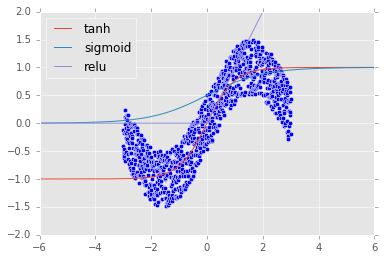

In [100]:
# lets use the same sin function anf plot the activation function on top of it.
xx = np.linspace(-6,6,1000)

tanh = tf.nn.tanh(xx).eval()
sigmoid = tf.nn.sigmoid(xx).eval()
relu = tf.nn.relu(xx).eval()

# fig, axs = plt.subplots(1,1, figsize=(10,10))
plt.scatter(xData, yData)
plt.plot(xx, tanh, label='tanh')
plt.plot(xx, sigmoid, label='sigmoid')
plt.plot(xx, relu, label='relu')
plt.legend(loc='upper left')
plt.xlim([-6,6])
plt.ylim([-2,2])
plt.grid('on')

In [16]:
# Let us now apply the tanh non linear unit and see if we get a good plot.
# The procedure is the same as above
numFeatures = 1
numOutUnits = 10

x = tf.placeholder(dtype='float32', shape=[None, numFeatures], name='x')
y = tf.placeholder(dtype='float32', shape=[None], name='y')

w = tf.Variable(tf.random_normal(dtype='float32', shape=[numFeatures, numOutUnits], stddev=0.1), name='weight')
b = tf.Variable(tf.constant(0, dtype='float32', shape=[numOutUnits]), 'bias')

y_predAll = tf.matmul(x, w) + b
y_predAll = tf.tanh(y_predAll)

y_pred = tf.reduce_sum(y_predAll, 1)

The mini Batch Size is:  200
Number of mini batches is:  5
Length of xInput is:  1000
Length of yInput is:  1000
shape of tensor object x is:  [None, 1]
shape of tensor object y is:  [None]
shape of tensor object y_pred is:  [None]
0.251145


/Users/sam/App-Setup/CondaENV/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


0.239556
0.222401
0.201412
0.180722
0.163041
0.148692
0.136653
0.126319
0.11762
0.110635


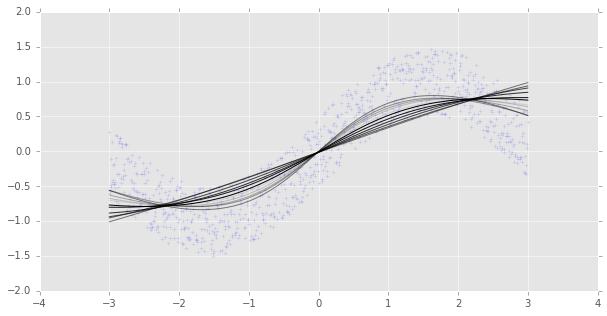

In [17]:
fig, axs = plt.subplots(1,1,figsize=(10,5))#,facecolor='w', edgecolor='k')
axs.scatter(xData, yData, alpha=0.15, marker='+')

numDataPoints = 1000
numBatches = 5
batchSize = numDataPoints // numBatches

# The input xData is not an nd array, here we convert it into nd array
xDataND = xData.reshape(numDataPoints, 1)
miniBatchLearning(xInput=xDataND, 
                  yInput=yData,
                  y_pred=y_pred,
                  learning_rate=0.02,
                  numDataPoints=numDataPoints,
                  batchSize=batchSize, 
                  numBatches=numBatches,
                  num_iteration=100) 